Deep Learning for Actuaries

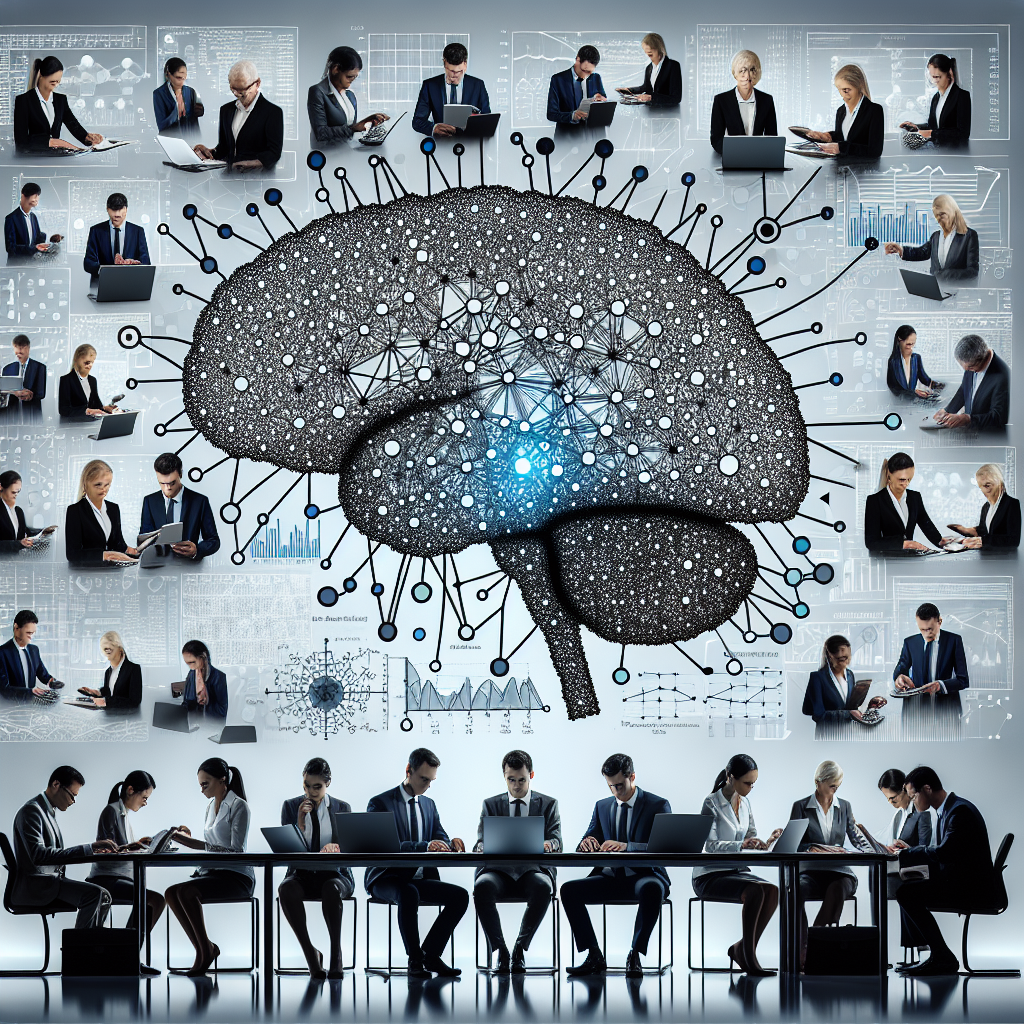

Load packages and data

In [ ]:
# Load packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models

from torch import nn
import torch
from skorch import NeuralNetRegressor
from torch.optim import NAdam

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
# Load the dataset (replace 'path_to_dataset.csv' with your actual file path)
data = pd.read_csv('C:/Users/R0626499/OneDrive - Allianz/Documents/Bart/Actuaris/DL_for_Actuaries/data/freMTPL2freq.csv')

# Inspect the dataset
data.head()

Data Preprocessing

Exposure weighting!!

In [ ]:
# Preprocess the Dataset
numerical_features = ['VehPower', 'VehAge', 'DrivAge','Density']
categorical_features = ['Area', 'VehBrand', 'VehGas','Region']

y = data['ClaimNb']
X = data.drop(columns=['ClaimNb','Exposure','IDpol'], axis=1)

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

exposure = data['Exposure']

# Split the dataset including the exposure
X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(
    X, y, exposure, test_size=0.2, random_state=42)


# Apply the preprocessing pipeline
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Model Evaluation

In [ ]:
def evaluate_model(model_name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

In [ ]:
def double_lift_chart(y_true, y_pred, num_bins=10):
    # Create a DataFrame with true and predicted values
    df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})

    # Create deciles based on predicted values
    df['Decile'] = pd.qcut(df['Predicted'], q=num_bins, labels=False)

    # Calculate average actual and predicted values for each decile
    decile_summary = df.groupby('Decile').agg({'Actual': 'mean', 'Predicted': 'mean'}).reset_index()

    # Plot the double lift chart
    plt.figure(figsize=(10, 6))
    plt.plot(decile_summary['Decile'], decile_summary['Actual'], marker='o', label='Actual')
    plt.plot(decile_summary['Decile'], decile_summary['Predicted'], marker='x', label='Predicted')
    plt.xlabel('Decile')
    plt.ylabel('Average Value')
    plt.title('Double Lift Chart')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with GLM predictions
#double_lift_chart(y_test, glm_preds_test)

# You can also use this function for other models, e.g., CANN, LocalGLMNet, TabNet
# double_lift_chart(y_test, cann_preds_test)
# double_lift_chart(y_test, localglmnet_preds_test)
# double_lift_chart(y_test, tabnet_preds_test)

GLM model

In [ ]:
# Fit a Generalized Linear Model (GLM) for frequency (Poisson)
glm = PoissonRegressor()
glm.fit(X_train, y_train, sample_weight=exposure_train)

# Get GLM predictions
glm_preds_train = glm.predict(X_train)
glm_preds_test = glm.predict(X_test)

In [ ]:
# Evaluate GLM
evaluate_model("GLM", y_test, glm_preds_test)

In [ ]:
double_lift_chart(y_test, glm_preds_test)

CANN

In [ ]:
# Add GLM predictions as features to the dataset
X_train = np.hstack((X_train.toarray(), glm_preds_train.reshape(-1, 1)))
X_test = np.hstack((X_test.toarray(), glm_preds_test.reshape(-1, 1)))

# Step 4: Build the Combined Actuarial Neural Network (CANN)
# Define the CANN model
input_shape = X_train.shape[1]

cann_model = models.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

cann_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the CANN model
cann_model.fit(X_train, y_train, sample_weight=exposure_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
# Evaluate CANN
cann_preds_test = cann_model.predict(X_test)
evaluate_model("CANN", y_test, cann_preds_test)

LocalGLMNet

In [ ]:
# Step 5: Build the LocalGLMNet Model
class LocalGLMNet(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes):
        super(LocalGLMNet, self).__init__()
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(input_size, hidden_layer_sizes[0])]
        )
        self.hidden_layers.extend(
            [
                nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i + 1])
                for i in range(len(hidden_layer_sizes) - 1)
            ]
        )
        self.last_hidden_layer = nn.Linear(hidden_layer_sizes[-1], input_size)
        self.output_layer = nn.Linear(1, 1)
        self.activation = nn.Tanh()
        self.inverse_link = torch.exp

    def forward(self, features, exposure=None, attentions=False):
        x = features
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.last_hidden_layer(x)
        if attentions:
            return x
        skip_connection = torch.einsum("ij,ij->i", x, features).unsqueeze(1)
        x = self.output_layer(skip_connection)
        x = self.inverse_link(x)
        if exposure is None:
            exposure = torch.ones_like(x, device=features.device)
        x = x * exposure
        return x

# Step 6: Train the LocalGLMNet Model
def train_model(X, v, y, device):
    localglmnet = NeuralNetRegressor(
        module=LocalGLMNet,
        max_epochs=10,
        criterion=nn.PoissonNLLLoss,
        criterion__log_input=False,
        module__input_size=X.shape[1],
        module__hidden_layer_sizes=[64, 32, 16],
        optimizer=NAdam,
        lr=0.01,
        batch_size=512,
        device=device,
    )

    X_dict = {"features": X, "exposure": v}
    localglmnet.fit(X_dict, y)
    return localglmnet

# Convert data to PyTorch tensors
X_train_torch = torch.FloatTensor(X_train)
y_train_torch = torch.FloatTensor(y_train.values)
X_test_torch = torch.FloatTensor(X_test)
y_test_torch = torch.FloatTensor(y_test.values)

# Example call to train the LocalGLMNet
trained_model = train_model(X_train_torch, np.ones_like(y_train_torch), y_train_torch, device='cpu')

# Evaluate LocalGLMNet
localglmnet_preds_test = trained_model.predict(X_test_torch).detach().numpy()
evaluate_model("LocalGLMNet", y_test, localglmnet_preds_test)

TabNet

In [ ]:
# Step 7: Build the TabNet Model
# Initialize and train the TabNet model
tabnet = TabNetRegressor()

y_train_normalized = y_train / exposure_train
y_test_normalized = y_test / exposure_test

# Train the TabNet model with normalized targets
tabnet.fit(X_train, y_train_normalized.values,
           eval_set=[(X_test, y_test_normalized.values)],
           eval_metric=['rmse'],
           max_epochs=50)

# Evaluate TabNet
tabnet_preds_test_normalized = tabnet.predict(X_test)
tabnet_preds_test = tabnet_preds_test_normalized * exposure_test
evaluate_model("TabNet", y_test, tabnet_preds_test)